## Classificazione con Decision Tree

In questa sezione si applica un **albero di decisione supervisionato** (DecisionTreeClassifier) per classificare i Pokémon in uno dei **quattro archetipi** individuati precedentemente tramite clustering:
- **Tank**
- **Bilanciati**
- **Offensivi**
- **Elite / Leggendari**

L’obiettivo è capire **quanto bene un modello interpretabile come l’albero** riesca a distinguere i Pokémon nei 4 archetipi, **utilizzando solo le quattro feature numeriche principali**:
- `OFF_FISICO`
- `OFF_SPECIALE`
- `TANK_FISICO`
- `TANK_SPECIALE`

tutte le altre feature come speed, hp etc. sono risultate in precedenti test non documentati poco
valide a fini dello splitting)
Il modello sarà validato mediante una **Stratified 10-Fold Cross Validation**, in modo da ottenere **medie e deviazioni standard** per ciascuna metrica (Accuracy, Precision, Recall, F1-score).

L'iper-parametro **min_samples_leaf** cosa significa?
È l’iperparametro che impone il numero minimo di esempi che un nodo foglia può contenere.
Se dopo uno split un nodo ha meno di min_samples_leaf esempi, quello split non viene fatto.
In pratica: impedisce che l’albero cresca rami deboli o su dati troppo rari.

In [1]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
import numpy as np

Caricamento del traning set e setup dell'ambiente
In questa sezione selezioniamo le 4 caratteristiche numeriche (offensive e difensive, fisiche e speciali) come input del modello.
Il target è la classe `Archetipo`, ovvero una delle 4 etichette: "Tank", "Bilanciati", "Attaccanti", "Elite/Leggendari".


In [2]:
TRAINING_PATH = "risorse/training_bilanciato.csv"
TEST_PATH     = "risorse/test_set.csv"
FEATURES = ["OFF_FISICO", "OFF_SPECIALE", "TANK_FISICO", "TANK_SPECIALE"]
TARGET   = "Archetipo"

df_train = pd.read_csv(TRAINING_PATH)
df_test  = pd.read_csv(TEST_PATH)

# Controllo colonne
missing_train = [c for c in FEATURES + [TARGET] if c not in df_train.columns]
missing_test  = [c for c in FEATURES + [TARGET] if c not in df_test.columns]
if missing_train:
    raise KeyError(f"Mancano colonne nel TRAINING SET: {missing_train}")
if missing_test:
    raise KeyError(f"Mancano colonne nel TEST SET: {missing_test}")

# Selezione e copia
df_train = df_train[FEATURES + [TARGET]].copy()
df_test  = df_test[FEATURES + [TARGET]].copy()

# Conversione a numerico
for c in FEATURES:
    df_train[c] = pd.to_numeric(df_train[c], errors="coerce")
    df_test[c]  = pd.to_numeric(df_test[c],  errors="coerce")

# Drop NaN (train e test)
before = len(df_train)
df_train = df_train.dropna(subset=FEATURES + [TARGET])
after = len(df_train)
if after < before:
    print(f"Attenzione: rimosse {before - after} righe (NaN) dal TRAINING.")

before_t = len(df_test)
df_test  = df_test.dropna(subset=FEATURES + [TARGET])
after_t  = len(df_test)
if after_t < before_t:
    print(f"Attenzione: rimosse {before_t - after_t} righe (NaN) dal TEST.")

# Distribuzioni classi
print("Distribuzione classi del TRAINING SET (y_train):")
x_train = df_train[FEATURES].values
y_train = df_train[TARGET].values
print(pd.Series(y_train).value_counts(normalize=True).round(2))
print(pd.Series(y_train).value_counts())

print("\nDistribuzione classi del TEST SET (y_test):")
x_test = df_test[FEATURES].values
y_test = df_test[TARGET].values
print(pd.Series(y_test).value_counts(normalize=True).round(2))
print(pd.Series(y_test).value_counts())

Distribuzione classi del TRAINING SET (y_train):
Balanced             0.25
Attaccante           0.25
Tank                 0.25
Elite/Leggendario    0.25
Name: proportion, dtype: float64
Balanced             245
Attaccante           245
Tank                 245
Elite/Leggendario    245
Name: count, dtype: int64

Distribuzione classi del TEST SET (y_test):
Attaccante           0.36
Balanced             0.31
Tank                 0.22
Elite/Leggendario    0.11
Name: proportion, dtype: float64
Attaccante           54
Balanced             47
Tank                 33
Elite/Leggendario    17
Name: count, dtype: int64


### Cross-validation su min_leaf
Per selezionare il valore ottimale dell'iper-parametro `min_leaf` dell'albero di decisione, eseguiamo una validazione incrociata (10-fold Stratified CV).
Registriamo media e deviazione standard per 4 metriche: accuracy, precision, recall, F1-macro.


In [3]:
# Valori da testare per la profondità dell'albero
MAX_DEPTH = 9
min_leaf_grid = [1, 2, 5, 10, 20, 30, 50, 70, 100]
# Definizione del K-Fold stratificato
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Metriche da calcolare in cross-validation
scoring = {
    "accuracy": "accuracy",
    "precision_macro": make_scorer(precision_score, average="macro", zero_division=0),
    "recall_macro": make_scorer(recall_score, average="macro", zero_division=0),
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
}

# Lista dei risultati
cv_results = []

# Ciclo su ciascun valore di profondità
for min_leaf in min_leaf_grid:
    clf = DecisionTreeClassifier(max_depth=MAX_DEPTH, min_samples_leaf=min_leaf, random_state=42)
    scores = cross_validate(clf, x_train, y_train, cv=cv, scoring=scoring)
    cv_results.append({
        "min_samples_leaf": min_leaf,
        "acc_mean":  scores["test_accuracy"].mean(),
        "acc_std":   scores["test_accuracy"].std(),

        "prec_mean": scores["test_precision_macro"].mean(),
        "prec_std":  scores["test_precision_macro"].std(),

        "rec_mean":  scores["test_recall_macro"].mean(),
        "rec_std":   scores["test_recall_macro"].std(),

        "f1_mean":   scores["test_f1_macro"].mean(),
        "f1_std":    scores["test_f1_macro"].std(),
    })

# Creazione del DataFrame con tutti i risultati
cv_table = pd.DataFrame(cv_results)

# Ordinamento per profondità crescente
cv_table = cv_table.sort_values("min_samples_leaf").reset_index(drop=True)

# Visualizzazione
pd.set_option("display.precision", 4)  # più leggibile
global_stats = {
    "Accuracy": f"{cv_table['acc_mean'].mean():.3f} ± {cv_table['acc_std'].mean():.3f}",
    "Precisione": f"{cv_table['prec_mean'].mean():.3f} ± {cv_table['prec_std'].mean():.3f}",
    "Richiamo": f"{cv_table['rec_mean'].mean():.3f} ± {cv_table['rec_std'].mean():.3f}",
    "F1-score": f"{cv_table['f1_mean'].mean():.3f} ± {cv_table['f1_std'].mean():.3f}",
}

# Tabella con valori "metric ± std"
display(cv_table)
df_global = pd.DataFrame(global_stats, index=["Media ± std su tutti i k"])
display(df_global)

,min_samples_leaf,acc_mean,acc_std,prec_mean,prec_std,rec_mean,rec_std,f1_mean,f1_std
0,1,0.9357,0.0233,0.9380,0.0222,0.9357,0.0232,0.9355,0.0230
1,2,0.9276,0.0334,0.9300,0.0327,0.9276,0.0333,0.9274,0.0334
2,5,0.9143,0.0224,0.9172,0.0210,0.9145,0.0225,0.9142,0.0218
3,10,0.8918,0.0388,0.8957,0.0372,0.8918,0.0388,0.8917,0.0382
4,20,0.8847,0.0289,0.8876,0.0310,0.8847,0.0294,0.8833,0.0299
5,30,0.8786,0.0256,0.8860,0.0254,0.8784,0.0260,0.8763,0.0275
6,50,0.8357,0.0394,0.8412,0.0410,0.8355,0.0393,0.8349,0.0402
7,70,0.8082,0.0319,0.8251,0.0364,0.8081,0.0323,0.8047,0.0322
8,100,0.7786,0.0289,0.7986,0.0290,0.7785,0.0298,0.7789,0.0310


,Accuracy,Precisione,Richiamo,F1-score
Media ± std su tutti i k,0.873 ± 0.030,0.880 ± 0.031,0.873 ± 0.031,0.872 ± 0.031


### Grafico: F1-score (media ± deviazione standard) in funzione di max_depth
Visualizziamo la variazione dell’F1 macro rispetto alla profondità dell’albero. Le barre verticali rappresentano l’incertezza della stima (± std).
Questa visualizzazione aiuta a scegliere un valore di `min_sample_leaf` che bilanci performance e stabilità, evitando l’overfitting (e undefitting).


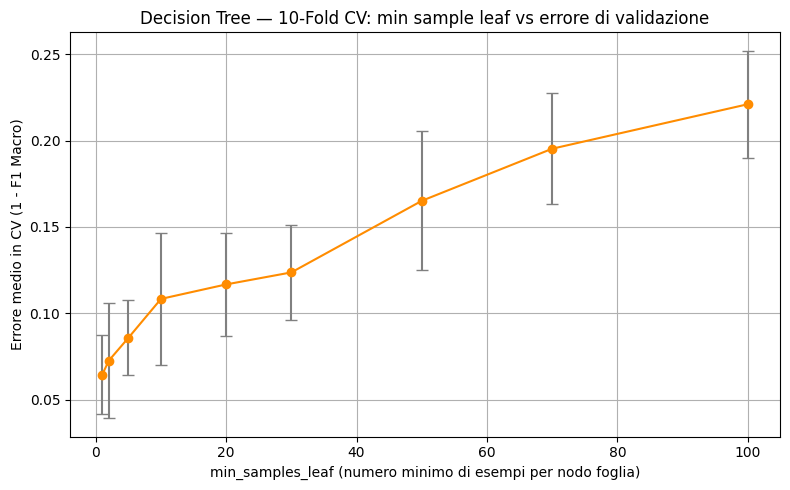

In [4]:
# === Analisi finale: errore medio e selezione best_depth ===
min_samples_leaf = cv_table["min_samples_leaf"]
mean_f1_errors = 1 - cv_table["f1_mean"]
std_f1_errors  = cv_table["f1_std"]

plt.figure(figsize=(8, 5))
plt.errorbar(
    min_samples_leaf,
    mean_f1_errors,
    yerr=std_f1_errors,
    fmt='-o',
    ecolor='gray',
    capsize=4,
    color='darkorange'
)

plt.xlabel("min_samples_leaf (numero minimo di esempi per nodo foglia)")
plt.ylabel("Errore medio in CV (1 - F1 Macro)")
plt.title("Decision Tree — 10-Fold CV: min sample leaf vs errore di validazione")
plt.grid(True)
plt.tight_layout()
plt.show()

### Selezione della profondità dell’albero (`min sample leaf`)

In [5]:
# Valore modificabile
BEST_MIN_SAMPLE_LEAF = 5

### Fit finale del Decision Tree sul training

In questo blocco:
- Addestriamo il modello Decision Tree sul training set bilanciato
- Valutiamo il modello appreso sul test set che prima di ora non è mai stato osservato dal modello
- Valutiamo il modello sul test set attraverso 4 metriche:
  - **Accuracy**
  - **Precisione macro**
  - **Richiamo macro**
  - **F1-score macro**
- Visualizziamo infine la **matrice di confusione** per analizzare gli errori.


Accuracy:     0.848
Precisione:   0.832
Richiamo:     0.827
F1-score:     0.827


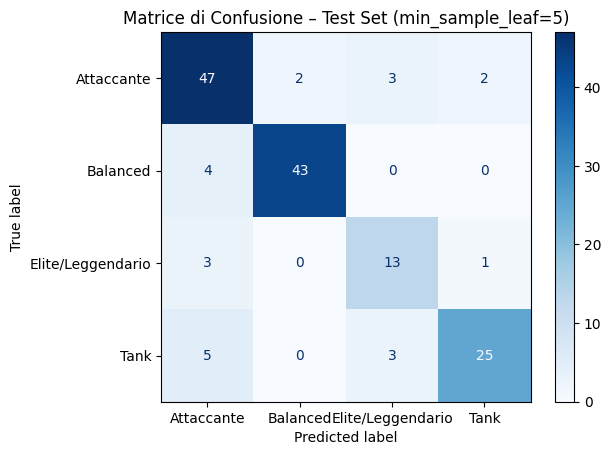

In [6]:
# Fit su training con profondità specificata
# criterio di split: Entropia
tree_clf = DecisionTreeClassifier(max_depth=MAX_DEPTH,
                                  min_samples_leaf=BEST_MIN_SAMPLE_LEAF,
                                  criterion="entropy", random_state=42)
tree_clf.fit(x_train, y_train)

# Previsioni sul test set
y_pred = tree_clf.predict(x_test)

# Calcolo metriche (la f1 risulta essere quella per noi più interessante)
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)

print(f"Accuracy:     {acc:.3f}")
print(f"Precisione:   {prec:.3f}")
print(f"Richiamo:     {rec:.3f}")
print(f"F1-score:     {f1:.3f}")

# Matrice di confusione
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    cmap="Blues",
    normalize=None
)
plt.title(f"Matrice di Confusione – Test Set (min_sample_leaf={BEST_MIN_SAMPLE_LEAF})")
plt.grid(False)
plt.show()

L’errore rimasto è plausibile: in realtà alcuni Pokémon ibridi sono davvero a metà strada tra Attaccante e Balanced/Tank, quindi la confusione riflette la natura dei dati, non un difetto del modello. Pertanto, alcuni errori di classificazioni sono assolutamente giustificabili.

Plottaggio dell'albero generato e classi più importanti

,Feature,Importanza
0,OFF_FISICO,0.3578
1,TANK_FISICO,0.2382
2,OFF_SPECIALE,0.2072
3,TANK_SPECIALE,0.1968


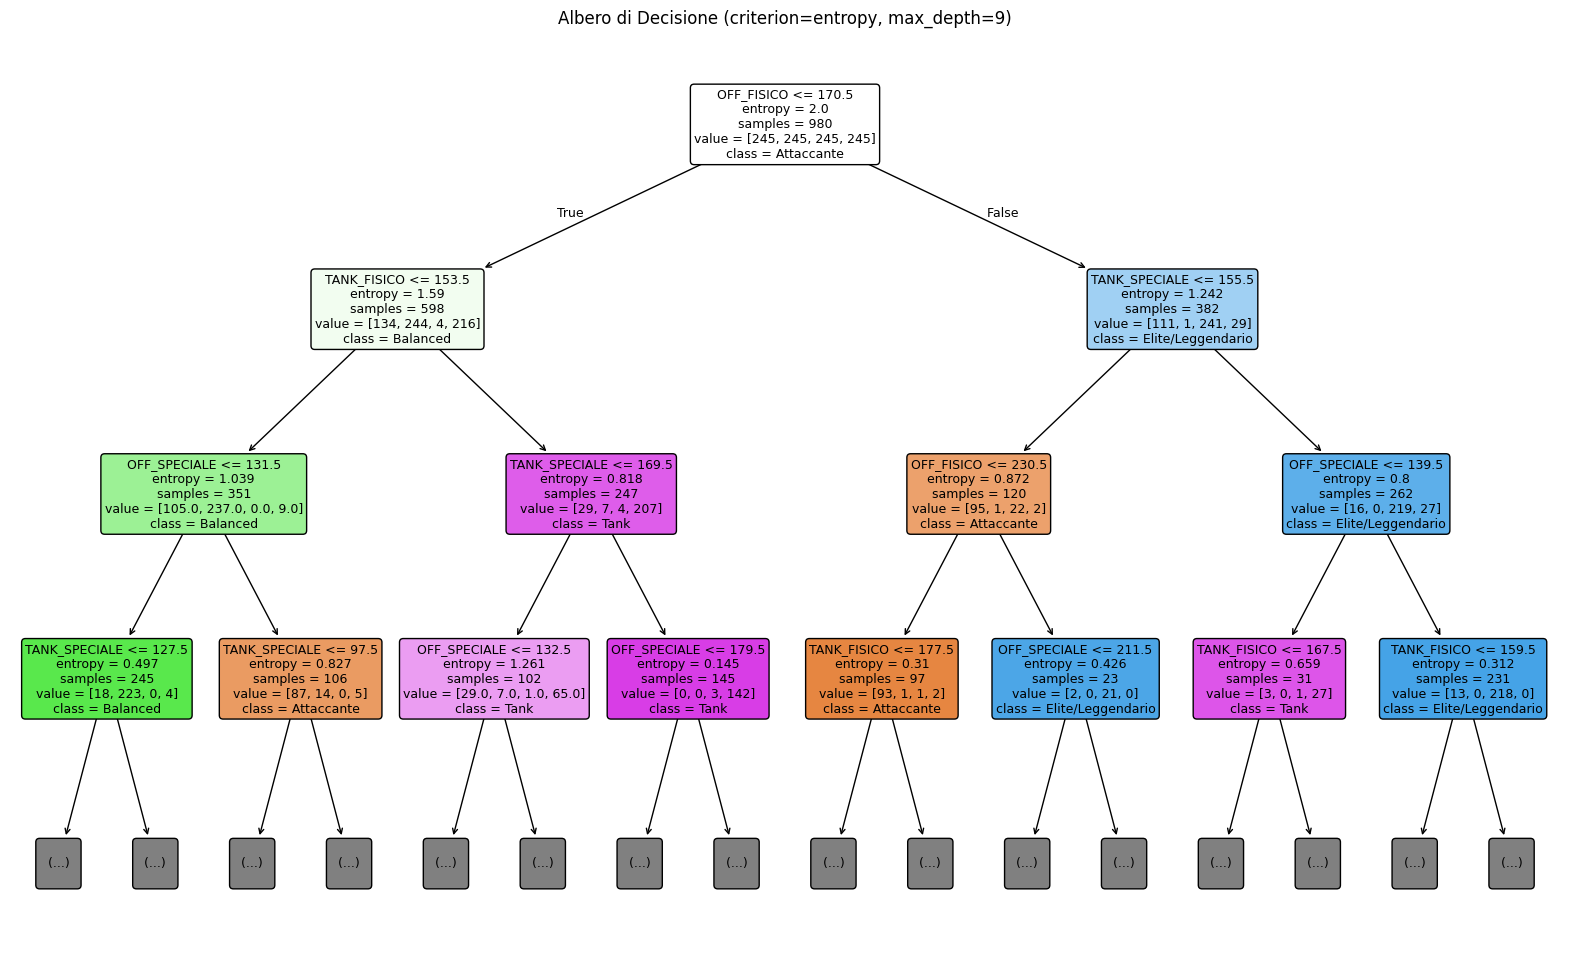

In [7]:
from sklearn.tree import plot_tree

feature_importances = tree_clf.feature_importances_
feature_names = np.array(FEATURES)

# Ordina in ordine decrescente
sorted_idx = np.argsort(feature_importances)[::-1]

df_importanza = pd.DataFrame({
    "Feature": feature_names[sorted_idx],
    "Importanza": feature_importances[sorted_idx]
})
df_importanza["Importanza"] = df_importanza["Importanza"].round(6)
display(df_importanza)

# Plottaggio dell'albero
plt.figure(figsize=(20, 12))
plot_tree(
    tree_clf,
    feature_names=FEATURES,
    class_names=sorted(pd.Series(y_train).unique()),
    filled=True,
    rounded=True,
    impurity=True,
    proportion=False,
    max_depth=3,
    fontsize=9
)
plt.title(f"Albero di Decisione (criterion=entropy, max_depth={tree_clf.get_params()['max_depth']})")
plt.show()

# 3) Salva su file (per la tesi)
plt.figure(figsize=(28, 16))
plot_tree(tree_clf, feature_names=FEATURES, class_names=sorted(pd.Series(y_train).unique()),
          filled=True, rounded=True, impurity=True, proportion=False, fontsize=10)
plt.title("Decision Tree")
plt.savefig("risorse/decision_tree.png", dpi=300, bbox_inches="tight")
plt.close()
#print("Salvato: risorse/decision_tree_colori.png")

Determiniamo le feature più importanti nello split.

L’albero di decisione ha assegnato maggiore importanza alla feature TANK_SPECIALE, segnalando che la componente difensiva speciale gioca un ruolo cruciale nella separazione tra gli archetipi.
Seguono le due componenti offensive (OFF_FISICO, OFF_SPECIALE) e infine la difesa fisica (TANK_FISICO).
Ciò suggerisce che i Pokémon con una forte difesa speciale vengono identificati come classe distinta più rapidamente.